In [1]:
import pandas as pd
from tqdm import tqdm
import gensim
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# os.chdir(r"D://Proposal_Defense//Simulations")
# from Utils.Script_utils import get_data_splits, first_LSTM_training, get_data_splits_old_algo
from joblib import Parallel, delayed
import sys
from scipy.stats import norm

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# # 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
# tf.config.set_visible_devices([], 'GPU')

from tqdm.notebook import tqdm
tf.random.set_seed(seed_value)
import multiprocessing
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
# from keras import backend as K
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)

No GPU found


In [3]:
import matplotlib.pyplot as plt

import pickle

In [4]:
model_cbow = gensim.models.word2vec.Word2Vec.load(r"..//Data_Generation//word2vec_sg")

In [5]:
lr = 1e-3

In [6]:
reps = 50

In [7]:
with open('..//Data_Generation//Data//train_valid_test_splits_50.pkl', 'rb') as f:
    catch = pickle.load(f)  

In [8]:
with open('..//Data_Generation//LSTM_Heavy_Dropout//heavy_dropout_first_lstm.pkl', 'rb') as f:
    first_lstm = pickle.load(f)  

    
with open('..//Data_Generation//LSTM_Heavy_Dropout//Heavy_Data_train_logits.pkl', 'rb') as f:
    catch_train_logits = (pickle.load(f))    

with open('..//Data_Generation//LSTM_Heavy_Dropout//Heavy_Data_valid_logits.pkl', 'rb') as f:
    catch_valid_logits = (pickle.load( f))      
    
with open('..//Data_Generation//LSTM_Heavy_Dropout//Heavy_Data_test_logits.pkl', 'rb') as f:
    catch_test_logits = (pickle.load( f))      
    

In [9]:
with open('..//Data_Generation//LSTM_Heavy_Dropout//heavy_dropout_second_lstm.pkl', 'rb') as f:
    second_lstm = pickle.load(f)  

In [10]:
def ann(hidden = 10): 
    input_layer = tf.keras.layers.Input(shape = (X_train_word2vec.shape[1]))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(1)
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [11]:
h1, h2 = 16,16

In [12]:
X_train_word2vec = first_lstm[0][3].numpy()

In [13]:


ann_15 = ann(h1)


# In[35]:


# ann_15.summary()


# In[36]:



In [14]:
ann_15.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense (Dense)               (None, 16)                416       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In [15]:
X_train_word2vec = model_cbow.wv.vectors

In [16]:
ann_20 = ann(h2)



# ann_20.summary()



In [17]:
total_weights_1 = ann_15.count_params()

In [18]:
total_weights_2 = ann_20.count_params()

In [19]:
total_weights = total_weights_1 + total_weights_2 + 1 

In [20]:
total_weights

1267

In [21]:
## batch size
batch_size = 32

In [22]:
# var_weights = 0.08
# var_targets = 0.08

In [23]:
from scipy.stats import multivariate_normal as mvn

In [24]:
from scipy.stats import invgamma, norm

In [25]:
from tqdm.notebook import tqdm

In [26]:
threshold = 5

In [27]:
import random

In [28]:
lr = 0.1

In [29]:
import numpy as np

In [30]:
weights_ann_1 = ann_15.get_weights()
weights_ann_2 = ann_20.get_weights()

In [31]:
def get_targets_with_weights(batch_data, batch_data1, initial_ensembles, log_sigma_points_1): 

    n_hidden_1 = len(weights_ann_1[0].ravel())

    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)

    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)



    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, 1)

    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + 1)].reshape(size_ens, 1, 1)



    final_output_1 = output_1 + output_layer_bias_1

    n_hidden_2 = len(weights_ann_2[0].ravel())

    initial_ensembles_1 = initial_ensembles.copy()[:, total_weights_1:(total_weights_1+ total_weights_2)]

    hidden_weights_2 = initial_ensembles_1[:,:n_hidden_2].reshape(size_ens, batch_data1.shape[1], h2)



    hidden_output_2 = np.einsum('ij,kjl->kil', batch_data1, hidden_weights_2)

    hidden_layer_bias_2 = initial_ensembles[:,n_hidden_2:(n_hidden_2 + h2)].reshape(size_ens, 1,  h2)

    hidden_output_2 = hidden_output_2+ hidden_layer_bias_2

    n_pred_weights_2 = len(weights_ann_2[2].ravel())

    output_weights_2 = initial_ensembles_1[:,(n_hidden_2 + h2):(n_hidden_2 + h2 + n_pred_weights_2) ].reshape(size_ens, h2, 1)


    output_2 = np.einsum('ijk,ikl->ijl', hidden_output_2, output_weights_2)


    output_layer_bias_2 = initial_ensembles_1[:,(n_hidden_2 + h2 + n_pred_weights_2):(n_hidden_2 + h2 + n_pred_weights_2 + 1)].reshape(size_ens, 1, 1)


    final_output_2 = output_2 + output_layer_bias_2


    weights_1 = initial_ensembles[:, :total_weights_1]

    weights_2 = initial_ensembles[:, total_weights_1:(total_weights_1 + total_weights_2)]


    avg_weights = initial_ensembles[:, -1].reshape(-1,1)

    avg_weights_sig = expit(avg_weights)
    
    avg_weights_sig = avg_weights_sig.reshape(avg_weights_sig.shape[0], 1, avg_weights_sig.shape[1])
    
    complement_weights_sig = 1 - expit(avg_weights)
    
    complement_weights_sig = complement_weights_sig.reshape(complement_weights_sig.shape[0], 1, complement_weights_sig.shape[1])

    final_output_1 = final_output_1*complement_weights_sig
    
    final_output_2 = final_output_2*avg_weights_sig
    
    output_1_ravel = final_output_1.reshape(size_ens, final_output_1.shape[1]*final_output_1.shape[2])

    output_2_ravel = final_output_2.reshape(size_ens, final_output_2.shape[1]*final_output_2.shape[2])


    output_1_ravel = output_1_ravel

    output_2_ravel = output_2_ravel



    weights_1_add = np.zeros((size_ens, (total_weights_2 - total_weights_1)))



    weights_1 = np.hstack((weights_1, weights_1_add))
    


    stack_1 = np.hstack((output_1_ravel, weights_1, np.repeat(0, size_ens).reshape(-1,1), np.repeat(0, size_ens).reshape(-1,1)))



    
    stack_2 = np.hstack((output_2_ravel, weights_2, avg_weights, log_sigma_points_1))

    
    initial_aug_state = np.hstack((stack_1, stack_2)) 
    

    return initial_aug_state , output_1_ravel, output_2_ravel, log_sigma_points_1



In [32]:
import time

In [33]:
from scipy.stats import multivariate_normal as mvn

In [34]:
var_weights =16
# var_weights_vec = 4
# var_targets = 0.04
# var_weights = 2

In [35]:
from scipy.stats import multivariate_normal as mvn

In [36]:
reduction = 8
# reduction = 10

In [37]:
shape_needed = (total_weights + 2*batch_size*1 + 1 + (total_weights_2 - total_weights_1))//reduction

In [38]:
size_ens = shape_needed

In [39]:
size_ens = int(size_ens)

In [40]:
size_ens

216

In [41]:
# train_fudged_probs

In [42]:
import matplotlib.pyplot as plt

In [43]:
from scipy.special import expit

In [44]:
catch1 = second_lstm

In [45]:
# catch1[0][0]

In [46]:
# catch1[0][3]

In [47]:
# len(catch1[0])

In [48]:
# catch_train_logits_second[0]

In [49]:
from datetime import datetime

In [50]:
doc2vec_dbow = gensim.models.doc2vec.Doc2Vec.load(r"..//Data_Generation//doc2vec_dbow")

In [51]:
# expit(np.vstack((catch_train_logits[0] , catch_valid_logits[0] )))

In [52]:
# expit(np.vstack((catch1[0][0], catch1[0][1])))

In [53]:
def rep_one(idx, inflation_factor = 0.2, cutoff = 100): 

#     from scipy.special import expit
    patience_smaller = 0
    patience_uns = 0
# patience_bigger = 0

#     best_train_acc = 0
#     best_valid_acc = 1000

#     best_valid_mae = 10
    
    best_train_width = 100
    
    X_train_logits = np.vstack((catch1[idx][0], catch1[idx][1]))
#     X_train_logits = catch_train_logits_second[idx]

    ## create training batch chunks
    train_idx = list(range(0, X_train_logits.shape[0]))
    batch_chunks = [train_idx[i:i+batch_size] for i in range(0,len(train_idx),batch_size)]

    ## generate some augmented variable for iteration 0
    initial_aug_state_mean = np.repeat(0, total_weights)
    initial_aug_state_mean = initial_aug_state_mean.reshape(-1,1)

    initial_aug_state_cov = var_weights*np.identity((total_weights))
    initial_ensembles = mvn(initial_aug_state_mean.reshape(initial_aug_state_mean.shape[0],), initial_aug_state_cov).rvs(size = size_ens)

    
    log_sigma_points_1 = (np.log(gamma(100, scale = 1/100).rvs(size_ens))).reshape(size_ens, 1)
    

#     y_train = catch_train_labels_second[idx]

#     y_valid = catch_valid_labels_second[idx]

#     y_test = catch_test_labels_second[idx]
    
    
    train_lstm = catch1[idx][3].numpy()
    valid_lstm = catch1[idx][4].numpy()
    # valid_word2vec = catch[idx][7].iloc[catch_valid_idxes[idx],:].reset_index(drop = True)
    test_lstm = catch1[idx][5].numpy()
 
    train_doc2vec = []
    for seq in catch[idx][0]:
        seq_txt = seq[0]
        seq_split = seq_txt.split(" ")
        train_doc2vec.append(doc2vec_dbow.infer_vector(seq_split))
    train_doc2vec = np.array(train_doc2vec)
    
    valid_doc2vec = []
    for seq in catch[idx][1]:
        seq_txt = seq[0]
        seq_split = seq_txt.split(" ")
        valid_doc2vec.append(doc2vec_dbow.infer_vector(seq_split))
    valid_doc2vec = np.array(valid_doc2vec)
    
    test_doc2vec = []
    for seq in catch[idx][2]:
        seq_txt = seq[0]
        seq_split = seq_txt.split(" ")
        test_doc2vec.append(doc2vec_dbow.infer_vector(seq_split))
    test_doc2vec = np.array(test_doc2vec)    
    
    train_valid_lstm = np.vstack((train_lstm, valid_lstm))
    train_valid_doc2vec = np.vstack((train_doc2vec, valid_doc2vec))
    
    # print(train_valid_lstm.shape, train_valid_doc2vec.shape)

    # best_width_train = 100
    
    threshold_achieved = False
    # satisfactory = False
    # satisfactory_counter = 0
    
    
    best_coverage_train = 0
    
    start=datetime.now()
    
    for iter1 in range(0,500):

        for batch_idx in batch_chunks:

            batch_data = train_valid_lstm[batch_idx,:]
            batch_data1 = train_valid_doc2vec[batch_idx,:]
            # print(batch_data.shape)
            batch_targets = X_train_logits[batch_idx,:]
            # batch_targets = batch_targets.ravel().reshape(-1,1)

            column_mod_2_shape = total_weights_2 + batch_data.shape[0]*1 + 1 + 1
        
            H_t = np.hstack((np.identity(batch_targets.shape[0]), np.zeros((batch_targets.shape[0], column_mod_2_shape-batch_targets.shape[0]))))

            current_aug_state, column_mod_1, column_mod_2, log_sigma_points_1 = get_targets_with_weights(batch_data, batch_data1, initial_ensembles, log_sigma_points_1)
            
            var_targets_vec = np.log(1 + np.exp(log_sigma_points_1))
            
            var_targets_vec = var_targets_vec
            
            # current_aug_state_var = np.cov(current_aug_state.T) + inflation_factor*np.identity(current_aug_state.shape[1])
            
            current_aug_state_var = np.cov(current_aug_state.T) 
            
            G_t = np.array([1 , 1]).reshape(-1,1)
            
            scirpt_H_t = np.kron(G_t.T, H_t)
            
            temp1 = current_aug_state_var@scirpt_H_t.T
            
            temp2 = scirpt_H_t@current_aug_state_var@scirpt_H_t.T
        
            for ensemble_idx in range(0, current_aug_state.shape[0]):
                
                var_targets1 = var_targets_vec[ensemble_idx,:]
                
                R_t = var_targets1*np.identity(batch_targets.shape[0])
            
                measurement_error = mvn(np.repeat(0,batch_targets.shape[0]), var_targets1*np.identity(batch_targets.shape[0])).rvs(1).reshape(-1,1)
            
                target_current = batch_targets + measurement_error
                
                K_t = temp1@np.linalg.inv(temp2 + R_t)

                current_aug_state[ensemble_idx,:] = current_aug_state[ensemble_idx,:] +(K_t@(target_current -scirpt_H_t@current_aug_state[ensemble_idx,:].reshape(-1,1))).reshape(current_aug_state.shape[1],)
        

            weights_ann_1 = current_aug_state[:,batch_targets.shape[0]:(batch_targets.shape[0] + total_weights_1)]      

            weights_ann_2 = current_aug_state[:,-(total_weights_2+1):-2]    

            initial_ensembles = np.hstack((weights_ann_1, weights_ann_2, current_aug_state[:,-2].reshape(-1,1)))
            
            log_sigma_points_1 = current_aug_state[:,-1].reshape(-1,1)
               
            avg_betas = expit(current_aug_state[:,-2])
        
            complement = 1-avg_betas

            
            
            
            
            current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(train_valid_lstm, train_valid_doc2vec, initial_ensembles, log_sigma_points_1)
            
            initial_targets = column_mod_11 + column_mod_21
            
            
            initial_targets = initial_targets.reshape(size_ens, train_valid_lstm.shape[0],1)
            
            initial_targets_train = initial_targets
            
            
#             ind = (X_train_logits_true >= np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[0,:,:]) & (X_train_logits_true <= np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[1,:,:])
        
            initial_targets_softmax = expit(initial_targets)
        
            initial_softmax_train = initial_targets_softmax
            
            li = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[0,:,:]
            
            ui = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[1,:,:]
            
            width = ui - li
            
            avg_width_train = np.mean(width)
            
            interim = expit(np.vstack((catch_train_logits[idx] , catch_valid_logits[idx] )))
            
            ind = (interim >= li) & (interim <= ui)
            
            coverage_train= np.mean(ind.ravel())  
            
            
        
            current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(test_lstm, test_doc2vec, initial_ensembles, log_sigma_points_1)
            
            initial_targets = column_mod_11 + column_mod_21
            
            initial_targets = initial_targets.reshape(size_ens, test_lstm.shape[0],1)
            
            initial_targets_test = initial_targets
            
            initial_targets_softmax = expit(initial_targets)    
            
            li = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[0,:,:]
            
            ui = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[1,:,:]
            
            width = ui - li
            
            avg_width = np.mean(width)
            
            ind_test = (expit(catch_test_logits[idx]) >= li) & (expit(catch_test_logits[idx]) <= ui)
               

                        
            coverage_test = np.mean(ind_test.ravel())    
            
            # test_mae = np.mean(np.abs(catch_test_probs[idx].ravel() - initial_targets.ravel()))
       
        # print(avg_width_train, best_train_width, coverage_train)
    
        # print("best train width is" + str(best_train_width))
              
    
        if (coverage_train > best_coverage_train) & (coverage_train < 0.95) & (threshold_achieved == False): 
            cur_best_train_width = avg_width_train
            cur_best_test_width = avg_width

            cur_best_train_coverage = coverage_train
            cur_best_test_coverage = coverage_test 
            cur_best_lstm_weight = np.mean(complement)
            best_coverage_train = coverage_train
            exit_iter_no_thresh = iter1
            best_test_preds = initial_targets_softmax
            patience_uns = 0
            threshold_achieved = False
            # satisfactory = True
            
        elif (coverage_train < best_coverage_train) & (coverage_train < 0.95)& (threshold_achieved == False): 
            patience_uns += 1
            
        else:
            pass
            # print("something wrong with less than 0.95 case", flush = True)
            
            
            
            
            
        
        if (avg_width_train < best_train_width) & (coverage_train >= 0.95):
            # print("going here")

            best_train_width = avg_width_train
            best_test_width = avg_width

            best_train_coverage = coverage_train
            best_test_coverage = coverage_test
            
            best_lstm_weight = np.mean(complement)

            patience_smaller = 0 
            
            threshold_achieved = True
            exit_iter_thresh = iter1
            best_test_preds = initial_targets_softmax
            
        elif (avg_width_train > best_train_width) & (coverage_train >= 0.95):
            patience_smaller +=1
            
        elif (threshold_achieved == True) & (coverage_train < 0.95):
            patience_smaller +=1
            
        else:
            pass
            # print("something wrong with greater than 0.95 case", flush = True)
            
            
        # print("epoch "+ str(iter1))
        # print("patience smaller "+ str(patience_smaller))
        # print("patience uns "+ str(patience_uns))
        # # print("test mae is " + str(test_mae))
        # print("train coverage is "+ str(coverage_train))
        # print("train width is " + str(avg_width_train))        
        # print("test coverage is "+ str(coverage_test))
        # print("test width is " + str(avg_width))
        # print("lstm weight is " + str(np.mean(complement)))
        # print("threshold " + str(threshold_achieved))
            
            
        if (threshold_achieved == True) & (coverage_train < 0.95) & (patience_smaller > threshold):
            # patience_smaller += 1 
            # if patience_smaller > threshold:
            print("thresh achieved", flush = True)
            stop = datetime.now()
            tt = stop-start
            mins = tt.seconds/60.0
            return best_train_coverage, best_test_coverage, best_train_width, best_test_width, best_lstm_weight, exit_iter_thresh, "thresh_achieved", mins ,best_test_preds
        
        elif (patience_uns > uns_iter_threshold) & (threshold_achieved == False):
            print("cutting off thresh not achieved", flush = True)
            stop = datetime.now()
            tt = stop-start
            mins = tt.seconds/60.0            
            return cur_best_train_coverage, cur_best_test_coverage, cur_best_train_width, cur_best_test_width, cur_best_lstm_weight, exit_iter_no_thresh,  "cutoff_thresh_not_achieved",mins, best_test_preds
        
        elif (patience_smaller > cutoff_threshold) & (threshold_achieved == True) & (coverage_train > 0.95):
            print("cutting off thresh achieved", flush = True)
            stop = datetime.now()
            tt = stop-start
            mins = tt.seconds/60.0              
            return best_train_coverage, best_test_coverage, best_train_width, best_test_width, best_lstm_weight, exit_iter_thresh, "cutoff_thresh_achieved",mins, best_test_preds
        
    print("something went awry", flush = True)

In [54]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [55]:
from scipy.stats import gamma

In [56]:
# second_lstm[0]

In [57]:
uns_iter_threshold = 30

In [58]:
threshold = 20

In [59]:
cutoff_threshold = 50

In [60]:
# reduction = 8
# var_weights = 1

In [61]:
cur_idx = 3

In [62]:
# %%time
best_train_coverage, best_test_coverage, best_train_width, best_test_width, best_lstm_weight, exit_iter_thresh, status, time_taken, best_test_preds = rep_one(cur_idx)

thresh achieved


In [63]:
best_train_coverage, best_test_coverage, best_train_width, best_test_width, best_lstm_weight, exit_iter_thresh,time_taken, status

(0.9696969696969697,
 1.0,
 0.2555537271695108,
 0.34272586576780006,
 0.999442596884757,
 35,
 0.7,
 'thresh_achieved')

In [64]:
# cur_idx = 16
# np.log(catch_test_probs[cur_idx]/(1-catch_test_probs[cur_idx]))

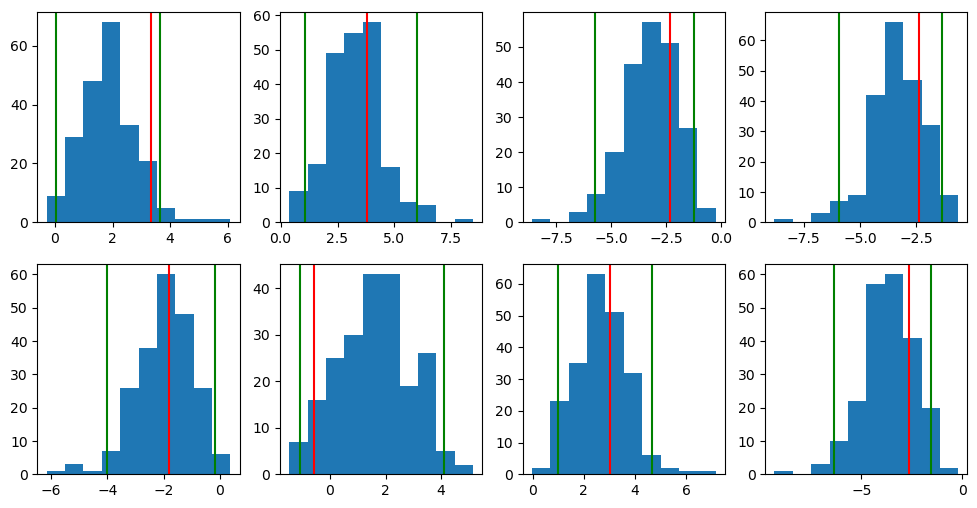

In [65]:
fig, axs = plt.subplots(2,4, figsize = (12,6))
axs = axs.ravel()

for i in range(0,8): 
    axs[i].hist(np.log(best_test_preds[:,i,:]/(1-best_test_preds[:,i,:])))
    ci = np.percentile(np.log(best_test_preds[:,i,:]/(1-best_test_preds[:,i,:])), q = (2.5, 97.5))
    l, u = ci[0], ci[1]
    axs[i].axvline(x=np.log(expit(catch_test_logits[cur_idx][i])/(1-expit(catch_test_logits[cur_idx][i]))), color = "red")
    axs[i].axvline(x=l, color = "green")
    axs[i].axvline(x=u, color = "green")

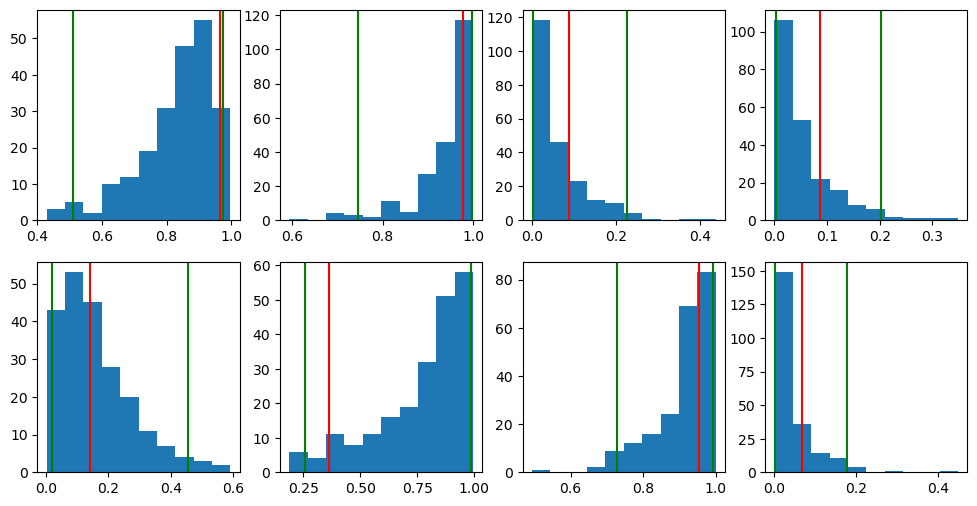

In [66]:
fig, axs = plt.subplots(2,4, figsize = (12,6))
axs = axs.ravel()

for i in range(0,8): 
    axs[i].hist(best_test_preds[:,i,:])
    ci = np.percentile(best_test_preds[:,i,:], q = (2.5, 97.5))
    l, u = ci[0], ci[1]
    axs[i].axvline(x=expit(catch_test_logits[cur_idx][i]), color = "red")
    axs[i].axvline(x=l, color = "green")
    axs[i].axvline(x=u, color = "green")

In [67]:
use_cores = multiprocessing.cpu_count()-1

In [68]:
catch_coverages = Parallel(n_jobs=15, verbose = 10, backend = "loky")(delayed(rep_one)(i) for i in range(reps))

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
/tmp/ipykernel_1313588/2467791455.py:4: RuntimeWarning: overflow encountered in exp


thresh achieved
thresh achieved


[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:   43.9s


thresh achieved
thresh achieved
thresh achieved


/tmp/ipykernel_1313588/2467791455.py:4: RuntimeWarning: overflow encountered in exp


thresh achieved
thresh achieved
thresh achieved
thresh achieved


/tmp/ipykernel_1313588/2467791455.py:4: RuntimeWarning: overflow encountered in exp


thresh achieved
thresh achieved


[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:  1.0min


thresh achieved


/tmp/ipykernel_1313588/2467791455.py:4: RuntimeWarning: overflow encountered in exp


thresh achieved


/tmp/ipykernel_1313588/2467791455.py:4: RuntimeWarning: overflow encountered in exp


thresh achieved
thresh achieved
thresh achieved
thresh achieved
thresh achieved
thresh achieved
thresh achieved


[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:  1.6min


thresh achieved
thresh achieved
thresh achieved
thresh achieved
thresh achieved
thresh achieved
thresh achieved


[Parallel(n_jobs=15)]: Done  27 out of  50 | elapsed:  2.1min remaining:  1.7min


thresh achieved
thresh achieved
thresh achieved
thresh achieved
thresh achieved


[Parallel(n_jobs=15)]: Done  33 out of  50 | elapsed:  2.3min remaining:  1.2min


thresh achieved
thresh achieved
thresh achieved
thresh achieved
thresh achieved
thresh achieved
thresh achieved


[Parallel(n_jobs=15)]: Done  39 out of  50 | elapsed:  2.6min remaining:   43.3s


thresh achieved
thresh achieved
thresh achieved
thresh achieved
thresh achieved
thresh achieved


[Parallel(n_jobs=15)]: Done  45 out of  50 | elapsed:  3.0min remaining:   19.8s


thresh achieved
thresh achieved
thresh achieved
thresh achieved
thresh achieved


[Parallel(n_jobs=15)]: Done  50 out of  50 | elapsed:  3.2min finished


In [69]:
check = pd.DataFrame(catch_coverages).iloc[:,:-1]

In [70]:
check.columns = ["train_coverage", "test_coverage", "avg_ci_width_train", "avg_ci_width_test", "avg_lstm_weight", "exit_iter", "exit_status", "time_taken"]

In [71]:
es = check[["exit_status"]].value_counts().reset_index()

In [72]:
es.columns = ["exit_status", "frequency"]

In [73]:
es.to_csv("exit_status_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens) + ".csv", index = False)

In [74]:
check = check.drop(["exit_status"],1)

/tmp/ipykernel_1313588/3676205243.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  check = check.drop(["exit_status"],1)


In [75]:
check_mean = check.mean().reset_index()

In [76]:
check_mean.columns = ["metrics", "value"]

In [77]:
check_mean.to_csv("mean_metrics_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens) +  ".csv", index = False)

In [78]:
check_mean

,metrics,value
0,train_coverage,0.962727
1,test_coverage,0.902500
2,avg_ci_width_train,0.311439
3,avg_ci_width_test,0.330261
4,avg_lstm_weight,0.999719
5,exit_iter,54.020000
6,time_taken,0.802667


In [79]:
check_median = check.median().reset_index()

In [80]:
check_median.columns = ["metrics", "value"]

In [81]:
check_median.to_csv("median_metrics_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens)+  ".csv", index = False)

In [82]:
# check.mean()

In [83]:
check_std = check.std().reset_index()

In [84]:
check_std.columns = ["metrics", "value"]

In [85]:
check_std.to_csv("std_dev_metrics_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens)+  ".csv", index = False)

In [86]:
# check.std()/np.sqrt(reps)

In [87]:
# with open('first_lstm_with_doc2vec_lstm_var_0.0001_real_world.pkl', 'rb') as f:
#     first_lstm = pickle.load(f)  

In [88]:
# threshold = 200
# cutoff_threshold = 70

In [89]:
# catch1 = first_lstm

In [90]:
# def rep_one_real_world(idx, inflation_factor = 0.2, cutoff = 100): 
#     catch_1 = []
#     catch_2 = []
#     catch_3 = []
#     catch_4 = []
#     catch_5 = []
# #     from scipy.special import expit
#     patience_smaller = 0
# # patience_bigger = 0

# #     best_train_acc = 0
# #     best_valid_acc = 1000

# #     best_valid_mae = 10
    
#     best_train_mae = 100
    
#     X_train_logits = np.vstack((catch1[idx][0], catch1[idx][1]))
# #     X_train_logits = catch_train_logits_second[idx]

#     ## create training batch chunks
#     train_idx = list(range(0, X_train_logits.shape[0]))
#     batch_chunks = [train_idx[i:i+batch_size] for i in range(0,len(train_idx),batch_size)]

#     ## generate some augmented variable for iteration 0
#     initial_aug_state_mean = np.repeat(0, total_weights)
#     initial_aug_state_mean = initial_aug_state_mean.reshape(-1,1)

#     initial_aug_state_cov = var_weights*np.identity((total_weights))
#     initial_ensembles = mvn(initial_aug_state_mean.reshape(initial_aug_state_mean.shape[0],), initial_aug_state_cov).rvs(size = size_ens)

    
#     log_sigma_points_1 = (np.log(gamma(100, scale = 1/100).rvs(size_ens))).reshape(size_ens, 1)
    

# #     y_train = catch_train_labels_second[idx]

# #     y_valid = catch_valid_labels_second[idx]

# #     y_test = catch_test_labels_second[idx]
    
    
#     train_lstm = catch1[idx][3].numpy()
#     valid_lstm = catch1[idx][4].numpy()
#     # valid_word2vec = catch[idx][7].iloc[catch_valid_idxes[idx],:].reset_index(drop = True)
#     test_lstm = catch1[idx][5].numpy()
 

#     train_doc2vec = catch[idx][6].values
#     valid_doc2vec = catch[idx][7].values
#     # valid_word2vec = catch[idx][7].iloc[catch_valid_idxes[idx],:].reset_index(drop = True)
#     test_doc2vec = catch[idx][8].values
    
    
    
#     train_valid_test_lstm = np.vstack((train_lstm, valid_lstm, test_lstm))
#     train_valid_test_doc2vec = np.vstack((train_doc2vec, valid_doc2vec, test_doc2vec))
    
#     train_valid_lstm = np.vstack((train_lstm, valid_lstm))
#     train_valid_doc2vec = np.vstack((train_doc2vec, valid_doc2vec))    

#     # best_width_train = 100
    
#     # threshold_achieved = False
#     # satisfactory = False
#     # satisfactory_counter = 0
    
    
#     best_coverage_train = 0
    
#     for iter1 in range(0,500):

#         for batch_idx in batch_chunks:

#             batch_data = train_valid_test_lstm[batch_idx,:]
#             batch_data1 = train_valid_test_doc2vec[batch_idx,:]
#             # print(batch_data.shape)
#             batch_targets = X_train_logits[batch_idx,:]
#             # batch_targets = batch_targets.ravel().reshape(-1,1)

#             column_mod_2_shape = total_weights_2 + batch_data.shape[0]*1 + 1 + 1
        
#             H_t = np.hstack((np.identity(batch_targets.shape[0]), np.zeros((batch_targets.shape[0], column_mod_2_shape-batch_targets.shape[0]))))

#             current_aug_state, column_mod_1, column_mod_2, log_sigma_points_1 = get_targets_with_weights(batch_data, batch_data1, initial_ensembles, log_sigma_points_1)
            
#             var_targets_vec = np.log(1 + np.exp(log_sigma_points_1))
            
#             var_targets_vec = var_targets_vec
            
#             # current_aug_state_var = np.cov(current_aug_state.T) + inflation_factor*np.identity(current_aug_state.shape[1])
            
#             current_aug_state_var = np.cov(current_aug_state.T) 
            
#             G_t = np.array([1 , 1]).reshape(-1,1)
            
#             scirpt_H_t = np.kron(G_t.T, H_t)
            
#             temp1 = current_aug_state_var@scirpt_H_t.T
            
#             temp2 = scirpt_H_t@current_aug_state_var@scirpt_H_t.T
        
#             for ensemble_idx in range(0, current_aug_state.shape[0]):
                
#                 var_targets1 = var_targets_vec[ensemble_idx,:]
                
#                 R_t = var_targets1*np.identity(batch_targets.shape[0])
            
#                 measurement_error = mvn(np.repeat(0,batch_targets.shape[0]), var_targets1*np.identity(batch_targets.shape[0])).rvs(1).reshape(-1,1)
            
#                 target_current = batch_targets + measurement_error
                
#                 K_t = temp1@np.linalg.inv(temp2 + R_t)

#                 current_aug_state[ensemble_idx,:] = current_aug_state[ensemble_idx,:] +(K_t@(target_current -scirpt_H_t@current_aug_state[ensemble_idx,:].reshape(-1,1))).reshape(current_aug_state.shape[1],)
        

#             weights_ann_1 = current_aug_state[:,batch_targets.shape[0]:(batch_targets.shape[0] + total_weights_1)]      

#             weights_ann_2 = current_aug_state[:,-(total_weights_2+1):-2]    

#             initial_ensembles = np.hstack((weights_ann_1, weights_ann_2, current_aug_state[:,-2].reshape(-1,1)))
            
#             log_sigma_points_1 = current_aug_state[:,-1].reshape(-1,1)
               
#             avg_betas = expit(current_aug_state[:,-2])
        
#             complement = 1-avg_betas

            
            
            
            
#             current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(train_valid_lstm, train_valid_doc2vec, initial_ensembles, log_sigma_points_1)
            
#             initial_targets = column_mod_11 + column_mod_21
            
            
#             initial_targets = initial_targets.reshape(size_ens, train_valid_lstm.shape[0],1)
            
#             initial_targets_train = initial_targets
            
            
            
            
# #             ind = (X_train_logits_true >= np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[0,:,:]) & (X_train_logits_true <= np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[1,:,:])
        
#             initial_targets_softmax = expit(initial_targets)
        
#             initial_softmax_train = initial_targets_softmax
            
#             initial_targets_train_mean = initial_targets_softmax.mean(0)
            
# #             li = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[0,:,:]
            
# #             ui = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[1,:,:]
            
# #             width = ui - li
            
# #             avg_width_train = np.mean(width)
            
#             interim = np.vstack((catch_train_probs[idx] , catch_valid_probs[idx] ))
            
# #             ind = (interim >= li) & (interim <= ui)
            
# #             coverage_train= np.mean(ind.ravel())  
            
#             train_mae = np.mean(np.abs(interim.ravel() - initial_targets_train_mean.ravel()))
        
#             current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(test_lstm, test_doc2vec, initial_ensembles, log_sigma_points_1)
            
#             initial_targets = column_mod_11 + column_mod_21
            
#             initial_targets = initial_targets.reshape(size_ens, test_lstm.shape[0],1)
            
#             initial_targets_test = initial_targets
            
#             initial_targets_softmax = expit(initial_targets)    
            
#             initial_targets_test_mean = initial_targets_softmax.mean(0)
# #             li = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[0,:,:]
            
# #             ui = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[1,:,:]
            
# #             width = ui - li
            
# #             avg_width = np.mean(width)
            
# #             ind_test = (catch_test_probs[idx] >= li) & (catch_test_probs[idx] <= ui)
               

                        
# #             coverage_test = np.mean(ind_test.ravel())    

#             # initial_targets_test_mean = initial_targets_train.mean(0)
            
#             test_mae = np.mean(np.abs(catch_test_probs[idx].ravel() - initial_targets_test_mean.ravel()))
       
#         # print(avg_width_train, best_train_width, coverage_train)
        
#         # print("epoch "+ str(iter1))
#         # print("patience "+ str(patience_smaller))
#         # print("train mae is " + str(train_mae))
#         # print("test mae is " + str(test_mae))

#         # print("train width is " + str(avg_width_train))        
#         # print("test coverage is "+ str(coverage_test))
#         # print("test width is " + str(avg_width))
#         # print("lstm weight is " + str(np.mean(complement)))
#         # print("threshold " + str(threshold_achieved))
              
    
#         if (train_mae < best_train_mae) : 
# #             cur_best_train_width = avg_width_train
# #             cur_best_test_width = avg_width

# #             cur_best_train_coverage = coverage_train
# #             cur_best_test_coverage = coverage_test 
# #             cur_best_lstm_weight = np.mean(complement)
#             best_train_mae = train_mae
#             best_test_mae = test_mae
#             exit_iter_no_thresh = iter1
#             best_test_preds = initial_targets_test_mean
#             patience_smaller = 0
#             # satisfactory = True
            
#         else:
#             patience_smaller+=1
            
#         if patience_smaller > threshold:
            
#             break
            
#         if (patience_smaller > cutoff_threshold) & (train_mae < 0.05):
            
#             break
            
            
#     print(best_test_mae, flush = True)
#     return best_train_mae, best_test_mae, exit_iter_no_thresh, best_test_preds
        
#     # print("something went awry", flush = True)

In [91]:
# threshold = 200

In [92]:
# cutoff_threshold = 100

In [93]:
# rep_one_real_world(3)

In [94]:
# catch_coverages = Parallel(n_jobs=use_cores, verbose = 10, backend = "loky")(delayed(rep_one_real_world)(i) for i in range(reps))

In [95]:
# catch_coverages

In [96]:
# check = pd.DataFrame(catch_coverages).iloc[:,:-1]

In [97]:
# check

In [98]:
# check

In [99]:
# check.columns = ["train_mae", "test_mae", "avg_ci_width_train", "avg_ci_width_test", "avg_lstm_weight", "exit_iter", "exit_status"]

In [100]:
# check

In [101]:
# check.columns = ["train_mae", "test_mae",  "exit_iter"]

In [102]:
# check.mean()

In [103]:
# check.std()

In [104]:
# check.std()/reps

In [105]:
# true_preds = []
# enkf_preds = []
# for i in range(0,reps):
#     all_preds = catch_coverages[i][-1]
#     # all_preds = all_preds.mean(0)
#     true_probs = catch_test_probs[i].ravel().tolist()
#     true_preds.append(true_probs)
#     enkf_preds.append(all_preds.ravel().tolist())
#     # plt.scatter(true_probs, all_preds.ravel().tolist())
#     # plt.show()

In [106]:
# true_preds = [inner for item in true_preds for inner in item]

In [107]:
# enkf_preds = [inner for item in enkf_preds for inner in item]

In [108]:
# np.mean(np.abs(np.array(true_preds)-np.array(enkf_preds)))

In [109]:
# plt.scatter(enkf_preds,true_preds, alpha=0.5)
# plt.xlabel("enkf preds")
# plt.ylabel("lstm preds")
# plt.axline((0, 0), slope=1)

In [110]:
# check